In [ ]:
! pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.3 MB/s eta 0:00:00


In [ ]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"

In [ ]:
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113
...,...,...,...
229,0,1.677,4860.269
230,0,2.323,787.749
231,1,1.761,9419.122
232,1,0.533,774.010


In [ ]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

<ipython-input-5-9934ef8c3e96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rgdppc_2000"] = np.log(df["rgdppc_2000"])


In [ ]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

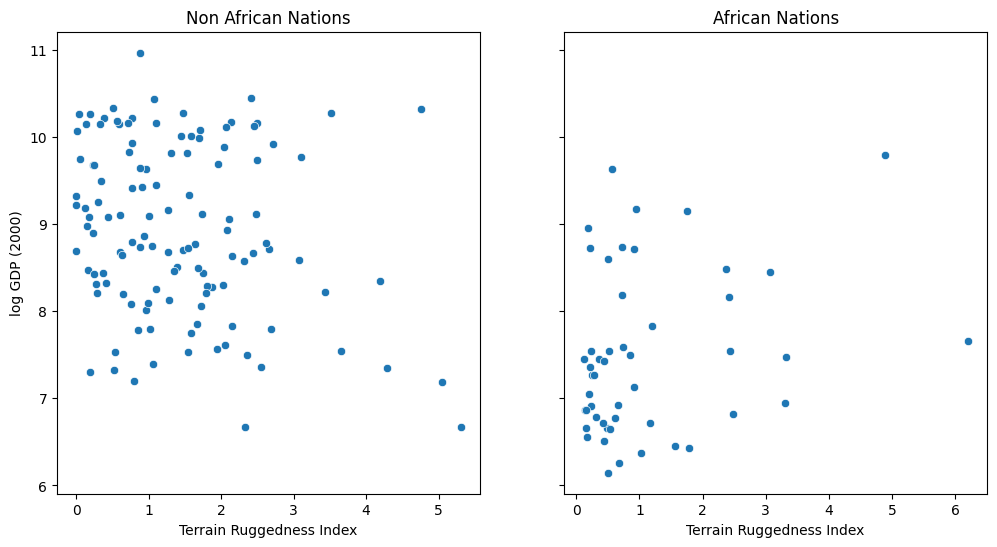

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

african_nations = df[df["cont_africa"]==1]
non_african_nations = df[df["cont_africa"]==0]

sns.scatterplot(x=non_african_nations["rugged"], y=non_african_nations["rgdppc_2000"], ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

sns.scatterplot(x=african_nations["rugged"], y=african_nations["rgdppc_2000"], ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations")

# maximum likelihood linear regression

In [ ]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
  a = pyro.param("a", lambda: torch.randn(()))
  b_a = pyro.param("b_a", lambda: torch.randn(()))
  b_r = pyro.param("b_r", lambda: torch.randn(()))
  b_ar = pyro.param("b_ar", lambda: torch.randn(()))

  sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)
  mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

  with pyro.plate("data", len(ruggedness)):
    return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

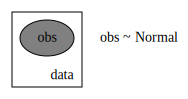

In [ ]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

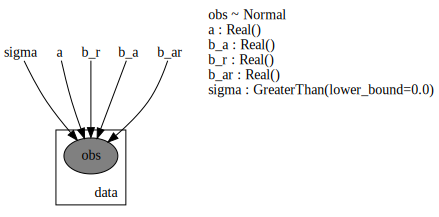

In [ ]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

In [ ]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(is_cont_africa, ruggedness, log_gdp=None):
  a = pyro.param("a", torch.tensor(0.0) )
  b_a = pyro.param("b_a", torch.tensor(0.0) )
  b_r = pyro.param("b_r", torch.tensor(0.0) )
  b_ar = pyro.param("b_ar", torch.tensor(0.0) )

  sigma = pyro.param("sigma", torch.tensor(1.0))
  mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

  with pyro.plate("data", len(ruggedness)):
    return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

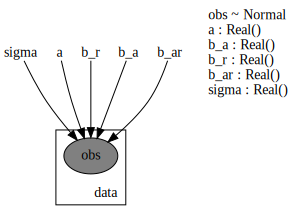

In [ ]:
pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

In [ ]:
%%time

pyro.clear_param_store()

# these should be reset each training loop
auto_guide = pyro.infer.autoguide.AutoNormal(model)

adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.

elbo = pyro.infer.Trace_ELBO()

svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

CPU times: user 410 µs, sys: 0 ns, total: 410 µs
Wall time: 416 µs


In [ ]:
losses = []

for step in range(1000):
  loss = svi.step(is_cont_africa, ruggedness, log_gdp)
  losses.append(loss)
  if step%100 == 0:
    print("Elbo loss: {}".format(loss))

Elbo loss: 6437.20947265625
Elbo loss: 964.9295043945312
Elbo loss: 649.7582397460938
Elbo loss: 538.8941040039062
Elbo loss: 483.6414794921875
Elbo loss: 451.5754089355469
Elbo loss: 430.9872741699219
Elbo loss: 416.5165100097656
Elbo loss: 405.4181823730469
Elbo loss: 396.1873779296875


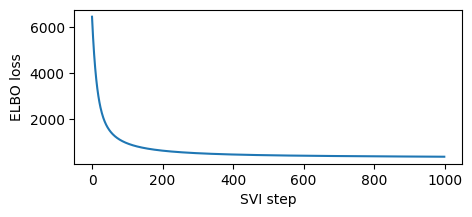

In [ ]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
for name, value in pyro.get_param_store().items():
  print(name, pyro.param(name).data.cpu().numpy())

a 5.116713
b_a 2.3457885
b_r 1.7732681
b_ar -1.6462946
sigma 2.6273568
